In [1]:
import pandas as pd
import neattext.functions as nfx
import matplotlib.pyplot as plt
import re
from sklearn.pipeline import Pipeline
from nltk.tokenize import RegexpTokenizer #Tokenizer that is used for custom tokenizer which we require now.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer#Term Frequency-Inverse Document Frequency dependents on our dataset tokens
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns

C:\Users\david\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\david\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\david\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Data Cleaning

In [2]:
df = pd.read_csv('data/british_airways_reviews.csv')
df

,Unnamed: 0,reviews
0,0,✅ Trip Verified | I have never seen such disr...
1,1,✅ Trip Verified | Paid for a 14 hour long fli...
2,2,✅ Trip Verified | Very inconsiderate PA annou...
3,3,"✅ Trip Verified | Absolutely terrible, lost m..."
4,4,✅ Trip Verified | We booked premium economy r...
...,...,...
3495,3495,JFK to LHR - Despite the image the BA TV show ...
3496,3496,Rome to London Gatwick. Delayed take-off from ...
3497,3497,LHR-Hannover Germany. You really wonder someti...
3498,3498,LGW to Alicante out on 8th September early fli...


In [3]:
df = df.drop('Unnamed: 0', axis =1)
df

,reviews
0,✅ Trip Verified | I have never seen such disr...
1,✅ Trip Verified | Paid for a 14 hour long fli...
2,✅ Trip Verified | Very inconsiderate PA annou...
3,"✅ Trip Verified | Absolutely terrible, lost m..."
4,✅ Trip Verified | We booked premium economy r...
...,...
3495,JFK to LHR - Despite the image the BA TV show ...
3496,Rome to London Gatwick. Delayed take-off from ...
3497,LHR-Hannover Germany. You really wonder someti...
3498,LGW to Alicante out on 8th September early fli...


In [4]:
df['reviews'][0]

'✅ Trip Verified |  I have never seen such disrespect to a customer. It was the 3rd time in 2 months that I was unable to do a check-in because of their website not working properly. Lost 2 hours on the phone with their customer service team. At the airport I was asked to check in my hand luggage because they had no more space in the cabin. I could not recline my seat and the staff was rude and unhelpful to me. The wifi was also not working. I made multiple complaints and no one ever even contacted me. Never using them again!'

In [5]:
#Cleaning dataset which contains unnecessary symbols and words that doesnot manke any sense in the review but creates a disturbance between words and model will be faulty
def preprocess(text):
    review = text.replace('✅ Trip Verified |  ', '')
    review = review.replace('✅ Verified Review |', '')
    review = review.replace('Trip Verified', '')
    review = review.replace('Not Verified', '')
    review = re.sub(r'[^\w\s\']',' ', review)
    review = re.sub("[ \n]+", " ", review)
    review = review.replace(r'\b(\w{1,3})\b', '')
    review = nfx.remove_multiple_spaces(review)
    review = nfx.remove_puncts(review)
    review = nfx.remove_punctuations(review)
    review = nfx.remove_userhandles(review)
    review = nfx.remove_special_characters(review)
    review = nfx.remove_stopwords(review)
    return review

In [6]:
df['Reviews']= df['reviews'].apply(preprocess)
df

,reviews,Reviews
0,✅ Trip Verified | I have never seen such disr...,seen disrespect customer 3rd time 2 months una...
1,✅ Trip Verified | Paid for a 14 hour long fli...,Paid 14 hour long flight ticket includes use f...
2,✅ Trip Verified | Very inconsiderate PA annou...,inconsiderate PA announcements purser appearin...
3,"✅ Trip Verified | Absolutely terrible, lost m...",Absolutely terrible lost luggage flights deliv...
4,✅ Trip Verified | We booked premium economy r...,booked premium economy round trip Phoenix Zuri...
...,...,...
3495,JFK to LHR - Despite the image the BA TV show ...,JFK LHR Despite image BA TV conveyed Galleries...
3496,Rome to London Gatwick. Delayed take-off from ...,Rome London Gatwick Delayed Rome largely plane...
3497,LHR-Hannover Germany. You really wonder someti...,LHR Hannover Germany wonder BA paid 940 return...
3498,LGW to Alicante out on 8th September early fli...,LGW Alicante 8th September early flight disapp...


# Data Transformation

In [7]:
Most_freq_words = pd.DataFrame(' '.join(df['Reviews']).split()).value_counts()[:50]
Most_freq_words

flight         6120
BA             4382
service        2546
London         2165
British        2158
seat           2122
Airways        2101
time           1973
crew           1856
seats          1852
good           1825
food           1778
cabin          1585
Heathrow       1484
class          1433
staff          1335
business       1139
flights        1101
hours          1042
check          1033
economy        1016
airline         997
passengers      981
plane           918
return          907
LHR             884
experience      880
fly             830
lounge          794
2               790
meal            781
hour            778
Club            774
aircraft        760
told            754
like            721
boarding        709
long            702
new             700
3               681
minutes         652
better          643
drinks          625
comfortable     616
customer        614
served          598
got             598
offered         589
way             582
airport         574


In [8]:
values = Most_freq_words.values
values

array([6120, 4382, 2546, 2165, 2158, 2122, 2101, 1973, 1856, 1852, 1825,
       1778, 1585, 1484, 1433, 1335, 1139, 1101, 1042, 1033, 1016,  997,
        981,  918,  907,  884,  880,  830,  794,  790,  781,  778,  774,
        760,  754,  721,  709,  702,  700,  681,  652,  643,  625,  616,
        614,  598,  598,  589,  582,  574], dtype=int64)

In [9]:
Most_freq_words[1]

4382

In [10]:
keys = []
for i in Most_freq_words.index:
    keys.append(i[0])

In [11]:
keys

['flight',
 'BA',
 'service',
 'London',
 'British',
 'seat',
 'Airways',
 'time',
 'crew',
 'seats',
 'good',
 'food',
 'cabin',
 'Heathrow',
 'class',
 'staff',
 'business',
 'flights',
 'hours',
 'check',
 'economy',
 'airline',
 'passengers',
 'plane',
 'return',
 'LHR',
 'experience',
 'fly',
 'lounge',
 '2',
 'meal',
 'hour',
 'Club',
 'aircraft',
 'told',
 'like',
 'boarding',
 'long',
 'new',
 '3',
 'minutes',
 'better',
 'drinks',
 'comfortable',
 'customer',
 'served',
 'got',
 'offered',
 'way',
 'airport']

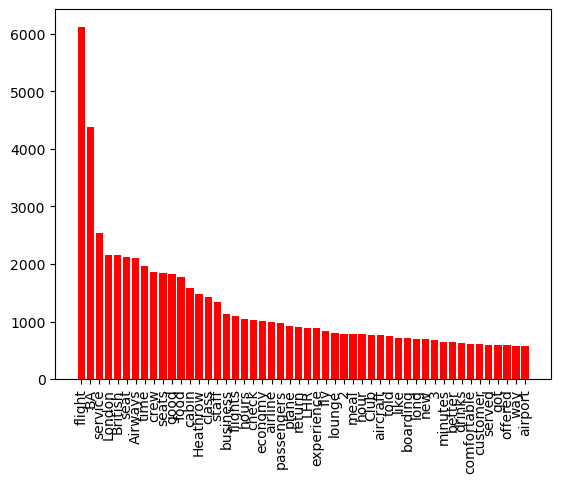

<Figure size 12000x5000 with 0 Axes>

In [12]:
plt.bar(keys, values, color='red')
plt.xticks(rotation=90)
plt.figure(figsize=(120, 50))
plt.show()

In [13]:
categories = ['negative', 'positive']
num_cat = len(categories)
num_cat

2

In [14]:
tokenizer = RegexpTokenizer(r'\b\w+\b')

In [15]:
vectorizer1 = CountVectorizer(lowercase=True, stop_words='english', tokenizer=tokenizer.tokenize)
vectorizer2 = TfidfVectorizer(lowercase=True, stop_words='english', tokenizer=tokenizer.tokenize)

In [16]:
kmeans1 = KMeans(n_clusters= 2)#2 beacause there are positive reviews and negative reviews
kmeans2 = KMeans(n_clusters= 2)#2 beacause there are positive reviews and negative reviews

In [17]:
pipeline1 = Pipeline([
    ('Count_Vectorizer', vectorizer1),
    ('kmeans', kmeans1)
])

In [18]:
pipeline2 = Pipeline([
    ('Tf-idf', vectorizer2),
    ('kmeans', kmeans2)
])

In [19]:
reviews = df['Reviews']
reviews

0       seen disrespect customer 3rd time 2 months una...
1       Paid 14 hour long flight ticket includes use f...
2       inconsiderate PA announcements purser appearin...
3       Absolutely terrible lost luggage flights deliv...
4       booked premium economy round trip Phoenix Zuri...
                              ...                        
3495    JFK LHR Despite image BA TV conveyed Galleries...
3496    Rome London Gatwick Delayed Rome largely plane...
3497    LHR Hannover Germany wonder BA paid 940 return...
3498    LGW Alicante 8th September early flight disapp...
3499    2 recent flights LHR SFO 12 hrs 7th Sept San D...
Name: Reviews, Length: 3500, dtype: object

In [20]:
cvt = pipeline1.fit_transform(reviews)
cvt

array([[ 6.5811084 ,  8.65354952],
       [12.14002582, 12.16341106],
       [14.17228709, 14.18896879],
       ...,
       [10.65497264, 10.62060553],
       [11.96369326, 11.42131802],
       [13.35813345, 13.8225445 ]])

In [21]:
tfidf = pipeline2.fit_transform(reviews)
tfidf

array([[0.97262979, 0.99616687],
       [0.98590549, 1.00135466],
       [0.98823626, 0.99469193],
       ...,
       [0.98763939, 0.97996773],
       [0.9696537 , 0.96837707],
       [0.99379088, 0.98387519]])

In [22]:
cntvct_lables = kmeans1.labels_
cntvct_lables

array([0, 0, 0, ..., 1, 1, 0])

In [23]:
tfidfcvt_labels = kmeans2.labels_
tfidfcvt_labels

array([0, 0, 0, ..., 1, 1, 1])

In [24]:
kmeans1.cluster_centers_

array([[0.00252434, 0.01226109, 0.00613054, ..., 0.00036062, 0.00901551,
        0.00036062],
       [0.00687758, 0.08940853, 0.02475928, ..., 0.        , 0.01788171,
        0.        ]])

In [25]:
kmeans2.cluster_centers_

array([[6.50979046e-04, 4.69427133e-03, 1.14366778e-03, ...,
        4.70454952e-05, 2.95280813e-03, 4.70454952e-05],
       [3.38432537e-04, 8.97570421e-04, 8.97375612e-04, ...,
        0.00000000e+00, 5.60943376e-04, 0.00000000e+00]])

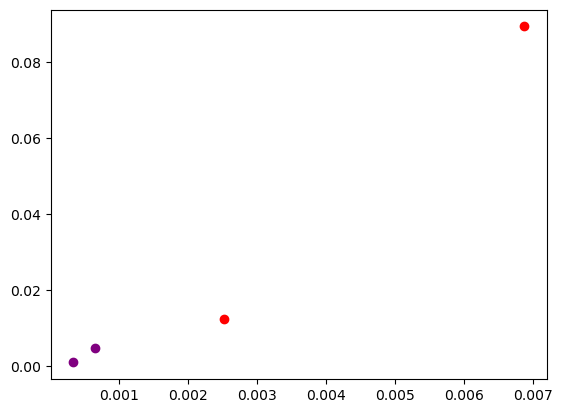

In [26]:
plt.scatter(kmeans1.cluster_centers_[:,0],kmeans1.cluster_centers_[:,1], color='red')
plt.scatter(kmeans2.cluster_centers_[:,0],kmeans2.cluster_centers_[:,1], color='purple')
plt.show()

In [27]:
reviews_df = pd.DataFrame(reviews)

In [28]:
reviews_df

,Reviews
0,seen disrespect customer 3rd time 2 months una...
1,Paid 14 hour long flight ticket includes use f...
2,inconsiderate PA announcements purser appearin...
3,Absolutely terrible lost luggage flights deliv...
4,booked premium economy round trip Phoenix Zuri...
...,...
3495,JFK LHR Despite image BA TV conveyed Galleries...
3496,Rome London Gatwick Delayed Rome largely plane...
3497,LHR Hannover Germany wonder BA paid 940 return...
3498,LGW Alicante 8th September early flight disapp...


In [29]:
reviews_df['Count_Vectorizer_labels'] = kmeans1.labels_
reviews_df['TFIDF_Vectorizer_labels'] = kmeans2.labels_

In [30]:
reviews_df

,Reviews,Count_Vectorizer_labels,TFIDF_Vectorizer_labels
0,seen disrespect customer 3rd time 2 months una...,0,0
1,Paid 14 hour long flight ticket includes use f...,0,0
2,inconsiderate PA announcements purser appearin...,0,0
3,Absolutely terrible lost luggage flights deliv...,0,0
4,booked premium economy round trip Phoenix Zuri...,1,0
...,...,...,...
3495,JFK LHR Despite image BA TV conveyed Galleries...,1,1
3496,Rome London Gatwick Delayed Rome largely plane...,0,1
3497,LHR Hannover Germany wonder BA paid 940 return...,1,1
3498,LGW Alicante 8th September early flight disapp...,1,1


In [31]:
reviews_df.Count_Vectorizer_labels.value_counts()

0    2773
1     727
Name: Count_Vectorizer_labels, dtype: int64

In [32]:
reviews_df.TFIDF_Vectorizer_labels.value_counts()

1    2085
0    1415
Name: TFIDF_Vectorizer_labels, dtype: int64

In [33]:
kmeans1.labels_

array([0, 0, 0, ..., 1, 1, 0])

In [34]:
kmeans2.labels_

array([0, 0, 0, ..., 1, 1, 1])

# Best Model

In [35]:
X, _ = make_blobs(n_samples=3500, centers=2, random_state=42)

In [36]:
X

array([[-1.29609992,  9.15600304],
       [-1.86647486, 10.34343866],
       [ 3.65433924,  1.00342596],
       ...,
       [-2.41113008, 10.31015791],
       [-4.17779688, 10.07301466],
       [ 3.80792392,  1.33488696]])

In [37]:
metrics.davies_bouldin_score(X, cntvct_lables)

222.21009093421807

In [38]:
metrics.davies_bouldin_score(X, tfidfcvt_labels)

37.52789530341253

So the TF-IDF performs best as the bouldin score suggests

# Model 

In [39]:
reviews

0       seen disrespect customer 3rd time 2 months una...
1       Paid 14 hour long flight ticket includes use f...
2       inconsiderate PA announcements purser appearin...
3       Absolutely terrible lost luggage flights deliv...
4       booked premium economy round trip Phoenix Zuri...
                              ...                        
3495    JFK LHR Despite image BA TV conveyed Galleries...
3496    Rome London Gatwick Delayed Rome largely plane...
3497    LHR Hannover Germany wonder BA paid 940 return...
3498    LGW Alicante 8th September early flight disapp...
3499    2 recent flights LHR SFO 12 hrs 7th Sept San D...
Name: Reviews, Length: 3500, dtype: object

In [40]:
Tfidfvectorizer_reviews = TfidfVectorizer(lowercase=True, stop_words='english', tokenizer=tokenizer.tokenize)

In [41]:
review_counts = Tfidfvectorizer_reviews.fit_transform(reviews)
review_counts

<3500x13668 sparse matrix of type '<class 'numpy.float64'>'
	with 221717 stored elements in Compressed Sparse Row format>

In [42]:
review_counts.shape

(3500, 13668)

In [43]:
kmeans_tfidf = KMeans(n_clusters= 2).fit(review_counts)

In [44]:
lables_ans = kmeans_tfidf.labels_
lables_ans

array([0, 0, 0, ..., 1, 1, 1])

In [45]:
output_df = pd.DataFrame(reviews)
output_df

,Reviews
0,seen disrespect customer 3rd time 2 months una...
1,Paid 14 hour long flight ticket includes use f...
2,inconsiderate PA announcements purser appearin...
3,Absolutely terrible lost luggage flights deliv...
4,booked premium economy round trip Phoenix Zuri...
...,...
3495,JFK LHR Despite image BA TV conveyed Galleries...
3496,Rome London Gatwick Delayed Rome largely plane...
3497,LHR Hannover Germany wonder BA paid 940 return...
3498,LGW Alicante 8th September early flight disapp...


In [46]:
output_df['labels'] = lables_ans

In [47]:
output_df # 0 is negative 1 is positive

,Reviews,labels
0,seen disrespect customer 3rd time 2 months una...,0
1,Paid 14 hour long flight ticket includes use f...,0
2,inconsiderate PA announcements purser appearin...,0
3,Absolutely terrible lost luggage flights deliv...,0
4,booked premium economy round trip Phoenix Zuri...,0
...,...,...
3495,JFK LHR Despite image BA TV conveyed Galleries...,1
3496,Rome London Gatwick Delayed Rome largely plane...,1
3497,LHR Hannover Germany wonder BA paid 940 return...,1
3498,LGW Alicante 8th September early flight disapp...,1


In [48]:
output_df.labels.value_counts()

1    2105
0    1395
Name: labels, dtype: int64

In [49]:
metrics.davies_bouldin_score(review_counts.toarray(), lables_ans)

12.499736369764745

In [50]:
metrics.silhouette_score(review_counts.toarray(), lables_ans, metric='euclidean')

0.006548344482234541

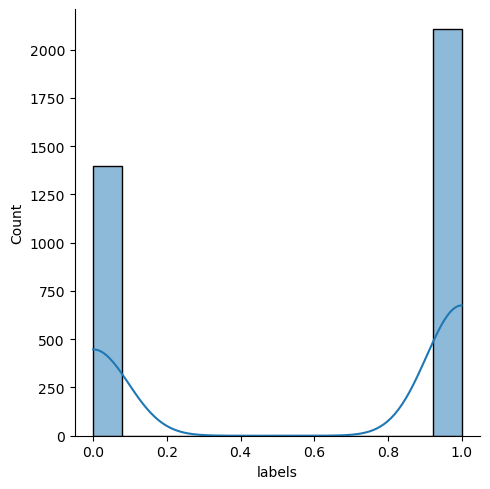

In [51]:
sns.displot(output_df['labels'], kde=True)

In [52]:
positive_reviews = output_df[output_df['labels']==1]
positive_reviews

,Reviews,labels
9,Check fast friendly Security breeze Lounge bus...,1
10,time seen new Club World suite seat comfortabl...,1
11,Flew business class Doha London 31st March ser...,1
12,Starting Heathrow Terminal 3 Check fairly easy...,1
14,minute business trip HND route regularly fly O...,1
...,...,...
3495,JFK LHR Despite image BA TV conveyed Galleries...,1
3496,Rome London Gatwick Delayed Rome largely plane...,1
3497,LHR Hannover Germany wonder BA paid 940 return...,1
3498,LGW Alicante 8th September early flight disapp...,1


In [53]:
negative_reviews = output_df[output_df['labels']==0]
negative_reviews

,Reviews,labels
0,seen disrespect customer 3rd time 2 months una...,0
1,Paid 14 hour long flight ticket includes use f...,0
2,inconsiderate PA announcements purser appearin...,0
3,Absolutely terrible lost luggage flights deliv...,0
4,booked premium economy round trip Phoenix Zuri...,0
...,...,...
3459,flew BA London Dulles DC 10 8 2014 Unfortunate...,0
3467,Dont think flying airline Booked paid confirme...,0
3468,LGW SZG Absolutely useless scheduled service r...,0
3474,Traveled Rome British Airways way went fine da...,0
